# HVAC Hybrid Model

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error

import seaborn as sns 
import matplotlib.pyplot as plt

import joblib
import os

pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)

In [2]:
hvac_data = pd.read_csv('hvac_model_zones.csv')

In [3]:
def transform_data(df_original):
    df = df_original.copy()
    df.columns = df.columns.str.replace(r"^b'|'$|\[.*?\]", "", regex=True)
    df = df.loc[df['Environment:Site Day Type Index'] != 0]

    df["HVAC_kWh"] = df["Electricity:HVAC"] * 2.77778e-7
    df.drop(columns='Electricity:HVAC', axis=1, inplace=True)

    occupant_cols = [col for col in df.columns if 'Occupant' in col]
    df["TotalOccCount"] = df[occupant_cols].sum(axis=1)
    df.drop(columns=occupant_cols, axis=1, inplace=True)
    
    lenOfData = len(df)
    df.index = pd.date_range(start="2004-01-01 00:00:00", periods=lenOfData, freq="10min")
    
    return df

hvac_data = transform_data(hvac_data)

In [4]:
def add_lags(df):
    for col in df.columns:
        target_map = df[col].to_dict()
        df[f'{col}_lag1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
        df[f'{col}_lag2'] = (df.index - pd.Timedelta('3 days')).map(target_map)
        df[f'{col}_lag3'] = (df.index - pd.Timedelta('7 days')).map(target_map)
        
    return df

hvac_data = add_lags(hvac_data)

In [5]:
def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

hvac_data = create_features(hvac_data)

In [6]:
features = ['weekofyear',
    'hour',
    'dayofmonth',
    'month',
    'HVAC_kWh_lag3',
    'TotalOccCount_lag3',
    'TotalOccCount_lag2',
    'TotalOccCount_lag1',
    'Environment:Site Day Type Index_lag1',
    'Environment:Site Outdoor Air Drybulb Temperature_lag2',
    'Environment:Site Outdoor Air Drybulb Temperature_lag1',
    'Environment:Site Outdoor Air Wetbulb Temperature_lag1',
    'Environment:Site Outdoor Air Wetbulb Temperature_lag3',
    'HVAC_kWh_lag1',
    'HVAC_kWh_lag2']

target = 'HVAC_kWh'
    
    
def feature_selection(df):
    df = df.bfill()
    X, y = df[features], df[target]
    
    return X, y

X, y = feature_selection(hvac_data)

In [7]:
def train_test_split(X, y):
    X_train, y_train = X[hvac_data.index.month <= 11], y[hvac_data.index.month <= 11]
    X_test, y_test = X[(hvac_data.index.month > 11) & (hvac_data.index.month <= 12)], y[(hvac_data.index.month > 11) & ((hvac_data.index.month <= 12))]
    
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = train_test_split(X, y)

In [8]:
def compute_metrics(test_data,forecast_mean):
    mae = mean_absolute_error(test_data, forecast_mean)
    mse = mean_squared_error(test_data, forecast_mean)
    rmse = np.sqrt(mse)


    metrics = {
        "mae":mae,
        "mse":mse,
        "rmse":rmse
    }

    return metrics

In [9]:
def train(X_train, y_train):
    lin_reg_hybrid_lags = LinearRegression()
    lin_reg_hybrid_lags.fit(X_train, y_train)

    y_train_residuals_hybrid_lags = y_train - pd.Series(lin_reg_hybrid_lags.predict(X_train), index=X_train.index)
    y_train_hybrid_lags = y_train_residuals_hybrid_lags
    xgb_reg_hybrid_lags = xgb.XGBRegressor(base_score=0.5,
                        booster='gbtree',
                        n_estimators=200,
                        objective='reg:squarederror',
                        max_depth=5,
                        learning_rate=0.05)
    xgb_reg_hybrid_lags.fit(X_train, y_train_hybrid_lags,
        verbose=100)
    
    return lin_reg_hybrid_lags, xgb_reg_hybrid_lags


lin_reg_hybrid_lags, xgb_reg_hybrid_lags = train(X_train, y_train)

In [10]:
def predict(lin_reg_hybrid_lags, xgb_reg_hybrid_lags, X_test):
    X_test = X_test.ffill()

    y_pred_lin_reg_lags = lin_reg_hybrid_lags.predict(X_test)
    y_pred_xgb_reg_lags = xgb_reg_hybrid_lags.predict(X_test)
    
    y_pred_combined_lags = y_pred_lin_reg_lags + y_pred_xgb_reg_lags
    y_pred_combined_lags = pd.Series(y_pred_combined_lags, index = X_test.index)
    
    return y_pred_combined_lags


y_pred_combined_lags = predict(lin_reg_hybrid_lags, xgb_reg_hybrid_lags, X_test)

In [11]:
def add_pred(hvac_data, y_pred_combined_lags):
    pred_df_hybrid_lags = hvac_data[(hvac_data.index.month > 11) & (hvac_data.index.month <= 12)]
    pred_df_hybrid_lags['Predictions'] = y_pred_combined_lags
    
    return pred_df_hybrid_lags

pred_df_hybrid_lags = add_pred(hvac_data, y_pred_combined_lags)

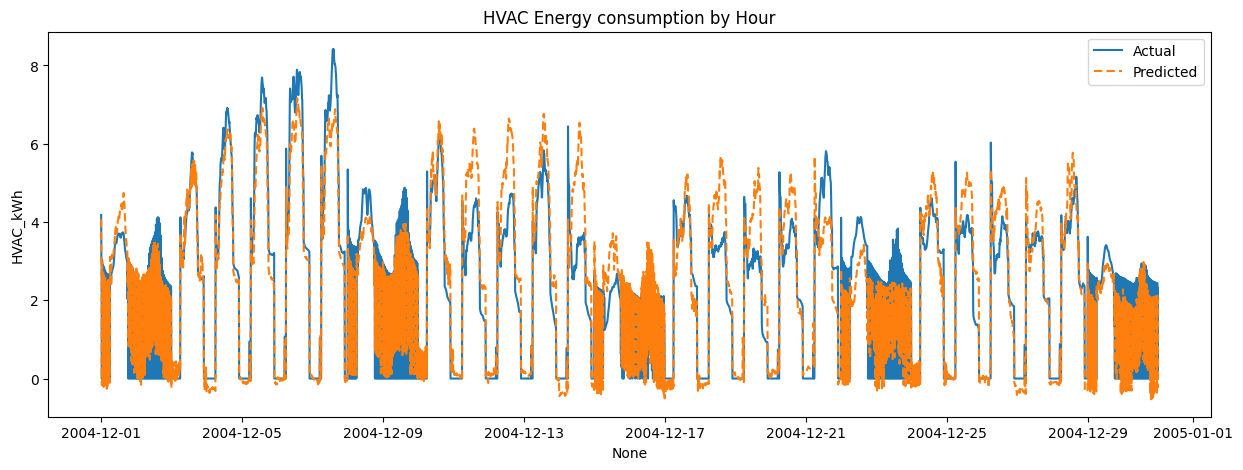

{'mae': 0.5340408814420665, 'mse': 0.5207612063099762, 'rmse': 0.7216378636892442}


In [12]:
def plot_results(pred_df_hybrid_lags):
    plt.figure(figsize=(15, 5))
    sns.lineplot(x=pred_df_hybrid_lags.index, y=pred_df_hybrid_lags['HVAC_kWh'], label='Actual')
    sns.lineplot(x=pred_df_hybrid_lags.index, y=pred_df_hybrid_lags['Predictions'], label='Predicted', dashes=(4,2))
    plt.title('HVAC Energy consumption by Hour')
    plt.legend()
    plt.show()

    print(compute_metrics(pred_df_hybrid_lags['HVAC_kWh'], pred_df_hybrid_lags['Predictions']))
    
plot_results(pred_df_hybrid_lags)

In [13]:
def save_model(lin_reg_hybrid_lags, xgb_reg_hybrid_lags):
    os.makedirs('HVAC_Model', exist_ok=True)
    joblib.dump(lin_reg_hybrid_lags, 'HVAC_Model/lin_reg_hybrid_lags.pkl')
    joblib.dump(xgb_reg_hybrid_lags, 'HVAC_Model/xgb_reg_hybrid_lags.pkl')
    print("Models saved successfully.")
    
save_model(lin_reg_hybrid_lags, xgb_reg_hybrid_lags)

Models saved successfully.


Forcasting the future

In [14]:
def load_model():
    lin_reg_hybrid_lags = joblib.load('HVAC_Model/lin_reg_hybrid_lags.pkl')
    xgb_reg_hybrid_lags = joblib.load('HVAC_Model/xgb_reg_hybrid_lags.pkl')
    print("Models loaded successfully.")
    
    return lin_reg_hybrid_lags, xgb_reg_hybrid_lags

lin_reg_hybrid_lags, xgb_reg_hybrid_lags = load_model()

Models loaded successfully.


In [15]:
def prep_future_data(X_train):
    future = pd.date_range(
        start=X_train.index.max() + pd.Timedelta(minutes=10),
        end=X_train.index.max() + pd.Timedelta(days=7),
        freq='10min'
    )
    future_df = pd.DataFrame(index=future)
    future_df['isFuture'] = True
    X_train['isFuture'] = False
    df_and_future = pd.concat([X_train, future_df])
    
    return df_and_future

df_and_future = prep_future_data(X_train)


In [16]:
def add_lags_test(df):
    for col in X.columns:
        target_map = df[col].to_dict()
        df[f'{col}'] = (df.index - pd.Timedelta('1 days')).map(target_map)
        df[f'{col}'] = (df.index - pd.Timedelta('3 days')).map(target_map)
        df[f'{col}'] = (df.index - pd.Timedelta('7 days')).map(target_map)
        
    return df

df_and_future = add_lags_test(df_and_future)

In [17]:
def create_features_test(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    
    return df

df_and_future = create_features_test(df_and_future)

In [18]:
def predict_future(lin_reg_hybrid_lags, xgb_reg_hybrid_lags, df_and_future):
    future_w_features = df_and_future.query('isFuture').copy()

    y_pred_lin_reg_lags = lin_reg_hybrid_lags.predict(future_w_features[features])
    y_pred_xgb_reg_lags = xgb_reg_hybrid_lags.predict(future_w_features[features])

    y_pred_combined_lags = y_pred_lin_reg_lags + y_pred_xgb_reg_lags
    y_pred_combined_lags = pd.Series(y_pred_combined_lags, index = future_w_features.index)
    
    return y_pred_combined_lags

y_pred_combined_lags = predict_future(lin_reg_hybrid_lags, xgb_reg_hybrid_lags, df_and_future)

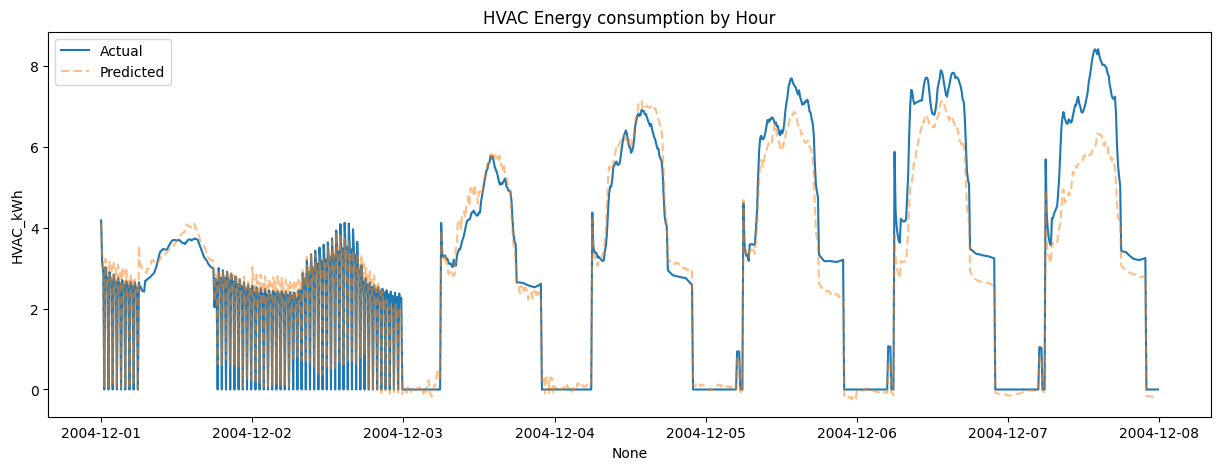

{'mae': 0.41508036005219784, 'mse': 0.38368621149002646, 'rmse': 0.6194240966333376}


In [19]:
def plot_future_predictions(y_pred_combined_lags, hvac_data):
    hvac_data = hvac_data.loc[y_pred_combined_lags.index]

    pred_df_hybrid_lags = hvac_data[(hvac_data.index.month > 11) & (hvac_data.index.month <= 12)]
    pred_df_hybrid_lags['Predictions'] = y_pred_combined_lags
    plt.figure(figsize=(15, 5))
    sns.lineplot(x=pred_df_hybrid_lags.index, y=pred_df_hybrid_lags['HVAC_kWh'], label='Actual')
    sns.lineplot(x=pred_df_hybrid_lags.index, y=pred_df_hybrid_lags['Predictions'], label='Predicted', dashes=(4,2), alpha=0.5)
    plt.title('HVAC Energy consumption by Hour')
    plt.legend()
    plt.show()
    print(compute_metrics(pred_df_hybrid_lags['HVAC_kWh'], pred_df_hybrid_lags['Predictions']))
    
plot_future_predictions(y_pred_combined_lags, hvac_data)

splitting the data into chunks

In [20]:
hvac_data_split = pd.read_csv('hvac_model_zones.csv')
lenOfData = len(hvac_data_split)
hvac_data_split.index = pd.date_range(start="2004-01-01 00:00:00", periods=lenOfData, freq="10min")

In [21]:
os.makedirs('../HVAC_Test_Data_Files', exist_ok=True)
hvac_data_split.to_csv('../HVAC_Test_Data_Files/hvac.csv', index=False)
hvac_test = hvac_data_split[hvac_data_split.index.month <= 11]
hvac_test.to_csv('../HVAC_Test_Data_Files/hvac_test.csv', index=False)
hvac_test1 = hvac_data_split[(hvac_data_split.index <= '2004-12-7 23:50:00')]
hvac_test1.to_csv('../HVAC_Test_Data_Files/hvac_test1.csv', index=False)
hvac_test2 = hvac_data_split[(hvac_data_split.index <= '2004-12-14 23:50:00')]
hvac_test2.to_csv('../HVAC_Test_Data_Files/hvac_test2.csv', index=False)
hvac_test3 = hvac_data_split[(hvac_data_split.index <= '2004-12-21 23:50:00')]
hvac_test3.to_csv('../HVAC_Test_Data_Files/hvac_test3.csv', index=False)
hvac_test4 = hvac_data_split[(hvac_data_split.index <= '2004-12-28 23:50:00')]
hvac_test4.to_csv('../HVAC_Test_Data_Files/hvac_test4.csv', index=False)

In [22]:
os.makedirs('../HVAC_Test_Data_Files', exist_ok=True)
# hvac_test = hvac_data_split[hvac_data_split.index.month <= 11]
# hvac_test.to_csv('../HVAC_Test_Data_Files/hvac_test.csv', index=False)
hvac_test_actual_1 = hvac_data_split[(hvac_data_split.index.day >= 1) & (hvac_data_split.index.day <= 7) & (hvac_data_split.index.month == 12)]
hvac_test_actual_1.to_csv('../HVAC_Test_Data_Files/hvac_test_actual_1.csv', index=False)
hvac_test_actual_2 = hvac_data_split[(hvac_data_split.index.day >= 1+7) & (hvac_data_split.index.day <= 7+7) & (hvac_data_split.index.month == 12)]
hvac_test_actual_2.to_csv('../HVAC_Test_Data_Files/hvac_test_actual_2.csv', index=False)
hvac_test_actual_3 = hvac_data_split[(hvac_data_split.index.day >= 1+7+7) & (hvac_data_split.index.day <= 7+7+7) & (hvac_data_split.index.month == 12)]
hvac_test_actual_3.to_csv('../HVAC_Test_Data_Files/hvac_test_actual_3.csv', index=False)
hvac_test_actual_4 = hvac_data_split[(hvac_data_split.index.day >= 1+7+7+7) & (hvac_data_split.index.day <= 7+7+7+7) & (hvac_data_split.index.month == 12)]
hvac_test_actual_4.to_csv('../HVAC_Test_Data_Files/hvac_test_actual_4.csv', index=False)

In [23]:
print(len(hvac_test))
print(len(hvac_test1))
print(len(hvac_test2))
print(len(hvac_test3))
print(len(hvac_test4))

48240
49248
50256
51264
52272
